# 0. Importing packages

In [1]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba
import warnings
warnings.simplefilter('always', RuntimeWarning)

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000','#006BA2','#DB444B','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from scipy.interpolate import interp1d
from types import SimpleNamespace

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# 1. Solving for steady state

The model to be solved can be written as:
$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t N_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t N_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{B}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{B}
\\
\mathcal{H}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{H}
\\
\varphi N_t^{\nu} \frac{1}{\theta}\left(C_{t}^\theta H_t^{1-\theta}\right)^\sigma\left(\frac{C_{t}}{H_t}\right)^{1-\theta} - w_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\quad t = 0, 1, \dots
$$

## 1.1. Household/HA block

Let's first construct our household/HA block to be used for both the steady state DAG and the transition DAG 

In [2]:
# load the HA block
hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

print(f'Inputs: {hh1.inputs}')
print(f'Macro outputs: {hh1.outputs}')
print(f'Micro outputs: {hh1.internals}')

Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'qh_lag', 'r', 'alpha', 'gamma_p', 'bmin', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Div', 'Tax']
Macro outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Vh_bhat', 'Vb_bhat', 'h_bhat', 'b_bhat', 'c_bhat', 'uce_bhat', 'chi', 'Psi1', 'b_bhat_grid', 'h_bhat_grid', 'k_grid', 'e_grid', 'pi_e', 'z_grid']


## 1.3. Creating the model and solving for steady state

In [3]:
blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, 
             utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'alpha', 'bmin', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'N', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi', 'BBAR', 'G', 'varphi', 'nu', 'HBAR']
Outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'w', 'qh_lag', 'gamma_p']


In [35]:
calibration = {'gamma': 0.8, 'theta': 0.97, 'sigma': 1.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
               'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}

calibration['alpha'] = 0.055
# calibration['rstar'] = 0.03/4
# calibration['gamma'] = 0.35
calibration_lowlev = calibration.copy()
calibration_lowlev['gamma'] = 0.0
calibration_lowlev['bmin'] = 0.215 #0.235 #-3.5159360338630137

# Calibrated parameters: beta (for goods market clearing), qh (for house market clearing), phi (for the wage schedule), w (for the Philips curve)
unknowns_ss = {'beta': 0.9793721660932323, 'varphi': 0.808535783494474, 'qh': 5.833330693740451}
# unknowns_ss = {'beta': 0.9758252694718823, 'varphi': 0.8002508849340744, 'qh': 4.681188976873863}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
ss =  hank_ss.steady_state(ss0)
MPC, mean_mpc = utils.calc_mpc(ss, 'hh_housecons')
print(f"Mean MPC: {mean_mpc}")
print(f"beta = {ss['beta']}, varphi = {ss['varphi']}, qh = {ss['qh']}")

# unknowns_ss = {'beta': 0.9727021787064672, 'varphi': 0.808341447169062, 'qh': 1.8859404457924365}
unknowns_ss = {'beta': 0.9684066031147929, 'varphi': 0.8085467478805278, 'qh': 3.171291418994175}
ss_ll = hank_ss.solve_steady_state(calibration_lowlev, unknowns_ss, targets_ss, solver="hybr")
MPC, mean_mpc = utils.calc_mpc(ss_ll, 'hh_housecons')
print(f"Mean MPC: {mean_mpc}")

Mean MPC: 0.12003252975877193
beta = 0.9790793068403952, varphi = 0.8084665353982551, qh = 5.751424070862137
Mean MPC: 0.12120273482926239


In [15]:
print(ss['gamma']*ss['HBAR']*ss['qh'])
# print(ss_ll['gamma']*ss_ll['HBAR']*ss_ll['qh'])
print(f"beta = {ss_ll['beta']}, varphi = {ss_ll['varphi']}, qh = {ss_ll['qh']}")

4.551238203163865
beta = 0.9670459692688677, varphi = 0.8085547261783594, qh = 2.961024261667389


In [49]:
from tabulate import tabulate

table_data = [
    ["Variable", "High leverage (gamma = 0.8)", "Low leverage (gamma = 0.2)"],
    ["Asset market clearing (untargeted)", f"{ss['asset_mkt']: 0.2e}", f"{ss_ll['asset_mkt']: 0.2e}"],
    ["Goods market clearing", f"{ss['goods_mkt']: 0.2e}", f"{ss_ll['goods_mkt']: 0.2e}"],
    ["Housing market clearing", f"{ss['house_mkt']: 0.2e}", f"{ss_ll['house_mkt']: 0.2e}"],
    ["Wage schedule residual", f"{ss['wage_res']: 0.2e}", f"{ss_ll['wage_res']: 0.2e}"],
    ["beta", ss['beta'], ss_ll['beta']],
    ["qh", ss['qh'], ss_ll['qh']],
    ["wage", ss['w'], ss_ll['w']],
    ["varphi", ss['varphi'], ss_ll['varphi']],
    ["Housing wealth, qh*H/(4*Y)", ss['H_BHAT']*ss['qh']/(4*ss['Y']), ss_ll['H_BHAT']*ss_ll['qh']/(4*ss_ll['Y'])],
    ["B_BHAT - qh*H_BHAT*gamma", ss['B_BHAT'] - ss['qh']*ss['H_BHAT']*ss['gamma'], ss_ll['B_BHAT'] - ss_ll['qh']*ss_ll['H_BHAT']*ss_ll['gamma']],
    ["Leverage, bhat/(4*Y)", ss['B_BHAT']/(4*ss['Y']), ss_ll['B_BHAT']/(4*ss_ll['Y'])],
    ["Chi", ss['CHI'], ss_ll['CHI']],
    ["Consumption", ss['C_BHAT'], ss_ll['C_BHAT']],
]

print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+------------------------------------+-------------------------------+------------------------------+
| Variable                           |   High leverage (gamma = 0.8) |   Low leverage (gamma = 0.2) |
+====================================+===============================+==============================+
| Asset market clearing (untargeted) |                   3.93e-07    |                  6.8e-07     |
+------------------------------------+-------------------------------+------------------------------+
| Goods market clearing              |                  -1.86e-16    |                 -2.96e-15    |
+------------------------------------+-------------------------------+------------------------------+
| Housing market clearing            |                  -2.22e-16    |                 -1.33e-15    |
+------------------------------------+-------------------------------+------------------------------+
| Wage schedule residual             |                   1.11e-16    |            

### 1.3.1. Plotting MPCs and distributions for different $\gamma$'s

In [ ]:
calibration = {'gamma': 0.6, 'theta': 0.97, 'sigma': 1.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
               'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}

calibration['alpha'] = 0.055
calibration['rstar'] = 0.03/4
gamma_list = np.linspace(0.5, 0.89, 10)
mean_mpc_list = []
bmargcum_list = np.zeros((len(gamma_list), calibration['nB']))
hmargcum_list = np.zeros((len(gamma_list), calibration['nH']))
MPC_dist_list = np.zeros((len(gamma_list), calibration['nZ'], calibration['nB'], calibration['nH']))

for igam, gamma in enumerate(gamma_list):
    try:
        print(f"Gamma: {gamma}")
        calibration['gamma'] = gamma
        ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
        ss =  hank_ss.steady_state(ss0)
        MPC, mean_mpc = utils.calc_mpc(ss, 'hh_housecons')
        mean_mpc_list.append(mean_mpc)
        MPC_dist_list[igam, :, :, :] = MPC

        if igam > 0:
            unknowns_ss = {'beta': ss['beta'], 'varphi': ss['varphi'], 'qh': ss['qh']}
        
        bdmargdist = np.sum(ss.internals['hh_housecons']['D'], axis=0)
        b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
        h_margdist = np.sum(bdmargdist,axis=0) # sum out bonds
        bmargcum = np.cumsum(b_margdist)
        hmargcum = np.cumsum(h_margdist)

        bmargcum_list[igam, :] = bmargcum
        hmargcum_list[igam, :] = hmargcum

    except ValueError as e:
        print(e)
        mean_mpc_list.append(np.nan)
        bmargcum_list[igam, :] = np.nan
        hmargcum_list[igam, :] = np.nan
        MPC_dist_list[igam, :, :, :] = np.nan
        print(f"Gamma: {gamma} failed")
        continue

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16,10))
ax = ax.flatten()

ax[0].plot(gamma_list, mean_mpc_list)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_title('Mean quarterly MPC')

for igam, gamma in enumerate(gamma_list):
    if igam % 2 == 0:
        ax[1].plot(ss.internals['hh_housecons']['b_bhat_grid'], bmargcum_list[igam, :], label = fr'$\gamma$ = {gamma:2.2f}')
    # ax[1].plot(ss.internals['hh_housecons']['b_bhat_grid'], bmargcum_list[igam, :], label = fr'$\gamma$ = {gamma:2.2f}')
ax[1].legend(ncols = 2, fontsize = 8)
ax[1].set_xlabel(r'$\hat b$')
ax[1].set_title('Cumulative distribution of $\hat b$')

for igam, gamma in enumerate(gamma_list):
    if igam % 2 == 0:
        ax[2].plot(ss.internals['hh_housecons']['h_bhat_grid'], hmargcum_list[igam, :], label = fr'$\gamma$ = {gamma:2.2f}')
    # ax[2].plot(ss.internals['hh_housecons']['h_bhat_grid'], hmargcum_list[igam, :], label = fr'$\gamma$ = {gamma:2.2f}')

ax[2].set_xlabel(r'$h$')
ax[2].set_title('Cumulative distribution of $h$')
ax[2].set_xlim(0, 1)

for igam, gamma in enumerate(gamma_list):
    ax[3].plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1], MPC_dist_list[igam, 2, :-1, 3], label = fr'$\gamma$ = {gamma:2.2f}')
ax[3].set_xlim(-0.1, 5.0)
ax[3].set_title('MPC distribution for $z = 0$')

plt.show()

In [ ]:
X, Y = np.meshgrid(ss.internals['hh_housecons']['h_bhat_grid'],ss.internals['hh_housecons']['b_bhat_grid'])
b_endo = ss.internals['hh_housecons']['b_bhat_grid'][:,None] \
            - ss['qh_lag']*ss['gamma']*ss.internals['hh_housecons']['h_bhat_grid'][None,:]

# Create a 3D plot
fig = plt.figure(figsize=(12, 12), dpi=400)
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# surf = ax.plot_surface(b_endo[:-1,:], X[:-1,:], MPC_dist_list[0, 2, :-1, :], cmap='viridis', alpha=0.75)
surf = ax.plot_surface(Y, X, MPC_dist_list[2, 1, :, :], cmap='viridis', alpha=0.75)
# ax.view_init(elev=30, azim=45)

### 1.3.2. Plotting the steady state policy functions

In [ ]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

z_point = 0
for i_h in range(0, calibration['nH'], 10):
    ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['c_bhat'][z_point,:, i_h], label=f'h = {ss.internals["hh_housecons"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['b_bhat'][z_point,:, i_h])

ax.legend()
ax.set_title('Consumption')
ax2.set_title('Housing')
ax3.set_title('Bond holdings')
fig.suptitle('Steady state policy functions', fontsize=14)
ax3.set_xlim([-0.01, 0.5])
ax3.set_ylim([0, 0.2])

plt.show()

Get the policy function for bond holdings

In [ ]:
# low_inc_dist = ss.internals['hh_housecons']['D'][0,:,:]
# b_dist = low_inc_dist - 
z_point = 0
b_point = 5
h_point = 5

b_endo = ss.internals['hh_housecons']['b_bhat_grid'][None,:] - ss['gamma'] * ss['qh'] * ss.internals['hh_housecons']['h_bhat_grid'][:,None]
b_polfunc = ss.internals['hh_housecons']['b_bhat'] - ss['gamma'] * ss['qh'] * ss.internals['hh_housecons']['h_bhat']
leverage_polfunc = -b_polfunc / (ss['qh'] * ss.internals['hh_housecons']['h_bhat'])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for iH in range(0, calibration['nH'], 2):
    ax.plot(b_endo[iH,:], b_polfunc[z_point,:, iH], label=f'h = {ss.internals["hh_housecons"]["h_bhat_grid"][iH]:.2f}')

# ax.plot(b_endo[h_point,:], b_polfunc[z_point,:, h_point])
ax.set_xlim(-2, 0.5)
ax.set_ylim(-10, 0.5)

# plot 2: leverage ratio
for iB in range(0, calibration['nB']-50):
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], leverage_polfunc[z_point,:, iB])

ax2.set_ylim(-1.0, ss['gamma'])
ax2.set_title('Optimal leverage ratio')
ax2.set_xlabel('Bond holdings')
ax2.set_ylabel(r'$b / q^h h$')
plt.show()

## 1.4. Plotting the steady state distributions

### 1.4.1. Housing and bond holdings

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# High leverage economy
bdmargdist = np.sum(ss.internals['hh_housecons']['D'],axis=0)
X, Y = np.meshgrid(ss.internals['hh_housecons']['h_bhat_grid'],ss.internals['hh_housecons']['b_bhat_grid'])
b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
bmargcum = np.cumsum(b_margdist)

# Low leverage economy 
bdmargdist_ll = np.sum(ss_ll.internals['hh_housecons']['D'],axis=0)
XX, YY = np.meshgrid(ss_ll.internals['hh_housecons']['h_bhat_grid'],ss_ll.internals['hh_housecons']['b_bhat_grid'])
b_margdist_ll = np.sum(bdmargdist_ll,axis=1) # sum out housing
bmargcum_ll = np.cumsum(b_margdist)

b_min =  - ss['qh_lag']*ss['gamma']*ss.internals['hh_housecons']['h_bhat_grid']

XX, YY = np.meshgrid(ss.internals['hh_housecons']['h_bhat_grid'],ss.internals['hh_housecons']['b_bhat_grid'])

b_endo = ss.internals['hh_housecons']['b_bhat_grid'][:,None] \
            - ss['qh_lag']*ss['gamma']*ss.internals['hh_housecons']['h_bhat_grid'][None,:]

b_endo_ll = ss_ll.internals['hh_housecons']['b_bhat_grid'][:,None] \
            - ss_ll['qh_lag']*ss_ll['gamma']*ss_ll.internals['hh_housecons']['h_bhat_grid'][None,:]

print(XX.shape)

# Create a 3D plot
fig = plt.figure(figsize=(12, 12), dpi=400)
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# surf = ax.plot_surface(b_endo, X, bdmargdist, cmap='viridis', alpha=0.5)
# surf2 = ax.plot_surface(b_endo_ll, XX, bdmargdist_ll, cmap='plasma', alpha=0.7)
surf2 = ax.plot_surface(b_endo, XX, ss.internals['hh_housecons']['D'][0,:,:], cmap='Oranges', alpha=0.7, label = ' z = 0')
surf2 = ax.plot_surface(b_endo, XX, ss.internals['hh_housecons']['D'][1,:,:], cmap='Greens', alpha=0.7, label = ' z = 2')
surf2 = ax.plot_surface(b_endo, XX, ss.internals['hh_housecons']['D'][2,:,:], cmap='Blues', alpha=0.7, label = ' z = 3')
ax.legend()
# surf = ax.plot_surface(Y, X, bdmargdist, cmap='viridis', alpha = 0.5)

plt.show()

In [ ]:
b_min =  - ss['qh_lag']*ss['gamma']*ss.internals['hh_housecons']['h_bhat_grid']
plt.plot(ss.internals['hh_housecons']['h_bhat_grid'], b_min, color='red')
# print(XX.shape)

In [ ]:
# getting the marginal distribution of bond holdings for low leverage economy
bdmargdist_ll = np.sum(ss_ll.internals['hh_housecons']['D'],axis=0)
b_margdist_ll = np.sum(bdmargdist_ll,axis=1) # sum out housing
bmargcum_ll = np.cumsum(b_margdist_ll)

mpc, mean_mpc = utils.calc_mpc(ss, 'hh_housecons')
mpc_ll, mean_mpc_ll = utils.calc_mpc(ss_ll, 'hh_housecons')

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# plot 1: marginal distribution of bond holdings across leverage ratios
ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], bmargcum, label = 'High leverage')
ax.plot(ss_ll.internals['hh_housecons']['b_bhat_grid'], bmargcum_ll, label = 'Low leverage')
ax.set_title('Cumulative distribution of bond holdings')
ax.legend()

# plot 2: MPCs across leverage ratios
h_idx = 20
ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],mpc[1,:-1,h_idx])
ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],mpc_ll[1,:-1,h_idx])
ax2.text(0.5, 0.95, f'High leverage avg. MPC {mean_mpc:.2f}', horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.5, 0.9, f'Low leverage avg. MPC {mean_mpc_ll:.2f}', horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)
ax2.set_title('Marginal propensity to consume')
ax2.set_xlabel('Bond holdings')
ax2.set_ylabel('MPC')

plt.show()


In [ ]:
z_point = 1
h_point = 66

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i_h in range(0, calibration['nB'], 1):
    if i_h%2 == 0:
        # ax.plot(ss.internals['hh_housecons']['h_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, i_h, :])
        pass
    else:
        ax.plot(ss.internals['hh_housecons']['h_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, i_h, :], ls = '--')

for i_h in range(0, calibration['nH'], 1):
    if i_h%2 == 0:
        ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, :, i_h])
    else:
        ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, :, i_h], ls = '--')

ax.set_title('Housing wealth')
ax2.set_title('Bond holdings')

plt.show()

### 1.4.2. MPCs

In [ ]:
# # MPC
# MPC = np.zeros(ss.internals['hh_housecons']['D'].shape)
# dc = (ss.internals['hh_housecons']['c_bhat'][:,1:,:]-ss.internals['hh_housecons']['c_bhat'][:,:-1,:])
# dm = (1+ss['r'])*ss.internals['hh_housecons']['b_bhat_grid'][np.newaxis,1:,np.newaxis]-(1+ss['r'])*ss.internals['hh_housecons']['b_bhat_grid'][np.newaxis,:-1,np.newaxis]
# MPC[:,:-1,:] = dc/dm
# MPC[:,-1,:] = MPC[:,-1,:] # assuming constant MPC at end
# mean_MPC = np.sum(MPC*ss.internals['hh_housecons']['D'])

MPC, mean_mpc = utils.calc_mpc(ss, 'hh_housecons')

h_point = 1
print(f'mean MPC: {mean_mpc:.3f}')
fig, ax = plt.subplots()
ax.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],MPC[1,:-1,h_point])
plt.show()

## 1.5. Solving model with seperability between housing and consumption

In [ ]:
# load the HA block and add inputs
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]
hank_ss_sep = create_model(blocks_ss, name="One-Asset HANK SS")

calibration2 = {'gamma': 0.8, 'theta': 0.03, 'sigma': 1.0, 'alpha': 1.0, 'bmax': 45,
               'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 0.15, 'HBAR': 1.0}

unknowns_ss = {'beta': 0.986, 'varphi': 0.08345079332201338, 'qh': 8.845303164603399}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0_sep = hank_ss_sep.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="hybr")
ss_sep =  hank_ss_sep.steady_state(ss0_sep)

print(f"beta: {ss_sep['beta']}")
print(f"varphi: {ss_sep['varphi']}")
print(f"SS qh: {ss_sep['qh']}")
print(f"qh*H/(4*Y): {ss_sep['H_BHAT']*ss_sep['qh']/(4*ss_sep['Y'])}")
print(f"Leverage: {ss_sep['B_BHAT']/(ss_sep['Y'])}")

In [ ]:
# calculate the endogenous grid for the bond holdings
b_endo = ss_sep.internals['hh_housecons_sep']['b_bhat_grid'][None,:] - ss_sep['gamma'] * ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat_grid'][:,None]

# calculate the policy function for the bond holdings and leverage ratio
b_polfunc = ss_sep.internals['hh_housecons_sep']['b_bhat'] - ss_sep['gamma'] * ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat']
leverage_polfunc = -b_polfunc / (ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat'])

### 1.6.1. Getting the distribution and MPC

In [ ]:
# average MPC
mpc, mean_mpc = utils.calc_mpc(ss_sep, 'hh_housecons_sep')
print(f'mean MPC: {mean_mpc:.3f}')

### 1.6.2. Plotting a dashboard 

In [ ]:
z_point = 0

# creating a plotting dashboard
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

for i_h in range(0, calibration2['nH'], 10):
    ax.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
            ss_sep.internals['hh_housecons_sep']['c_bhat'][z_point,:, i_h], label=f'h = {ss_sep.internals["hh_housecons_sep"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['b_bhat'][z_point,:, i_h])
    
for i_b in range(0, calibration2['nB'], 6):
    ax4.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['c_bhat'][z_point, i_b, :], 
             label=f'b = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][i_b]:.2f}')
    
for iB in range(0, calibration2['nB'], 4):
    ax5.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], leverage_polfunc[z_point, iB, :], 
             label=fr'$\hat b$ = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][iB]:.1f}')

for iH in range(0, calibration2['nH'], 2):
    ax6.plot(b_endo[iH,:], leverage_polfunc[z_point, :, iH])

ax.set_title('Consumption')
ax.set_xlabel(r'$\hat b$')
ax.legend(fontsize=8, ncol=3)

ax2.set_title('Housing')
ax2.set_xlabel(r'$\hat b$')

ax3.set_xlabel(r'$\hat b$')
ax3.set_title('Next-period bond holdings')

ax4.set_xlabel('Housing')
ax4.set_title('Consumption as a function of housing')

ax5.set_ylim(0.0, ss_sep['gamma']*1.1)
ax5.set_xlim(-0.01, 2.0)
ax5.set_title('Optimal leverage ratio')
ax5.set_xlabel('Housing')
ax5.set_ylabel(r'Leverage $(b / q^h h)$')
# ax5.axhline(ss_sep['gamma'], linestyle='--', color='blue', linewidth=2.5, alpha=0.5)
ax5.legend(ncols = 3, fontsize=8)

ax6.set_ylim(0.0, ss_sep['gamma']*1.1)
ax6.set_xlim(None, 2.0)
ax6.set_title('Optimal leverage ratio')
ax6.set_ylabel(r'Leverage $(b / q^h h)$')
ax6.set_xlabel('Bond holdings')

plt.show()

In [ ]:
z_point = 1
h_point = 66

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)

for i_b in range(0, calibration2['nB']-20, 2):
    if i_b%2 == 0:
        ax.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], ss_sep.internals['hh_housecons_sep']['D'][z_point, i_b, :], label=f'b = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][i_b]:.2f}')
    else:
        ax.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], ss_sep.internals['hh_housecons_sep']['D'][z_point, i_b, :], ls = '--', label=f'b = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][i_b]:.2f}')

ax.set_title('Housing wealth')
ax.set_xlabel('Housing')
ax.legend(fontsize = 8, ncols = 3)
ax.set_xlim(0.0, 1.0)

ax2.set_title('Bond holdings')
plt.show()

# 2. Transitional dynamics

## 2.1. Building the DAG for transitional dynamics

Have to do a sligth modification of the DAG for transitional dyanmics, because the `nkpc_ss` block is not valid for anything but steady state. Note this code should always be run before

In [36]:
# General settings for the model
T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

In [37]:
blocks = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, 
          utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]
hank = create_model(blocks, name="Housing HANK")

# Checking that the steady state DAG created above is valid
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

### Temporary debugging of the code 

In [41]:
rho_r, sig_r = 0.5, 0.0025
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

ss = hank.steady_state(ss0)
ss_nocol = hank.steady_state(ss_ll)

irfs_col = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, verbose = False)
irfs_nocol = hank.solve_impulse_linear(ss_nocol, unknowns, targets, rstar_shock, verbose = False)

4 3


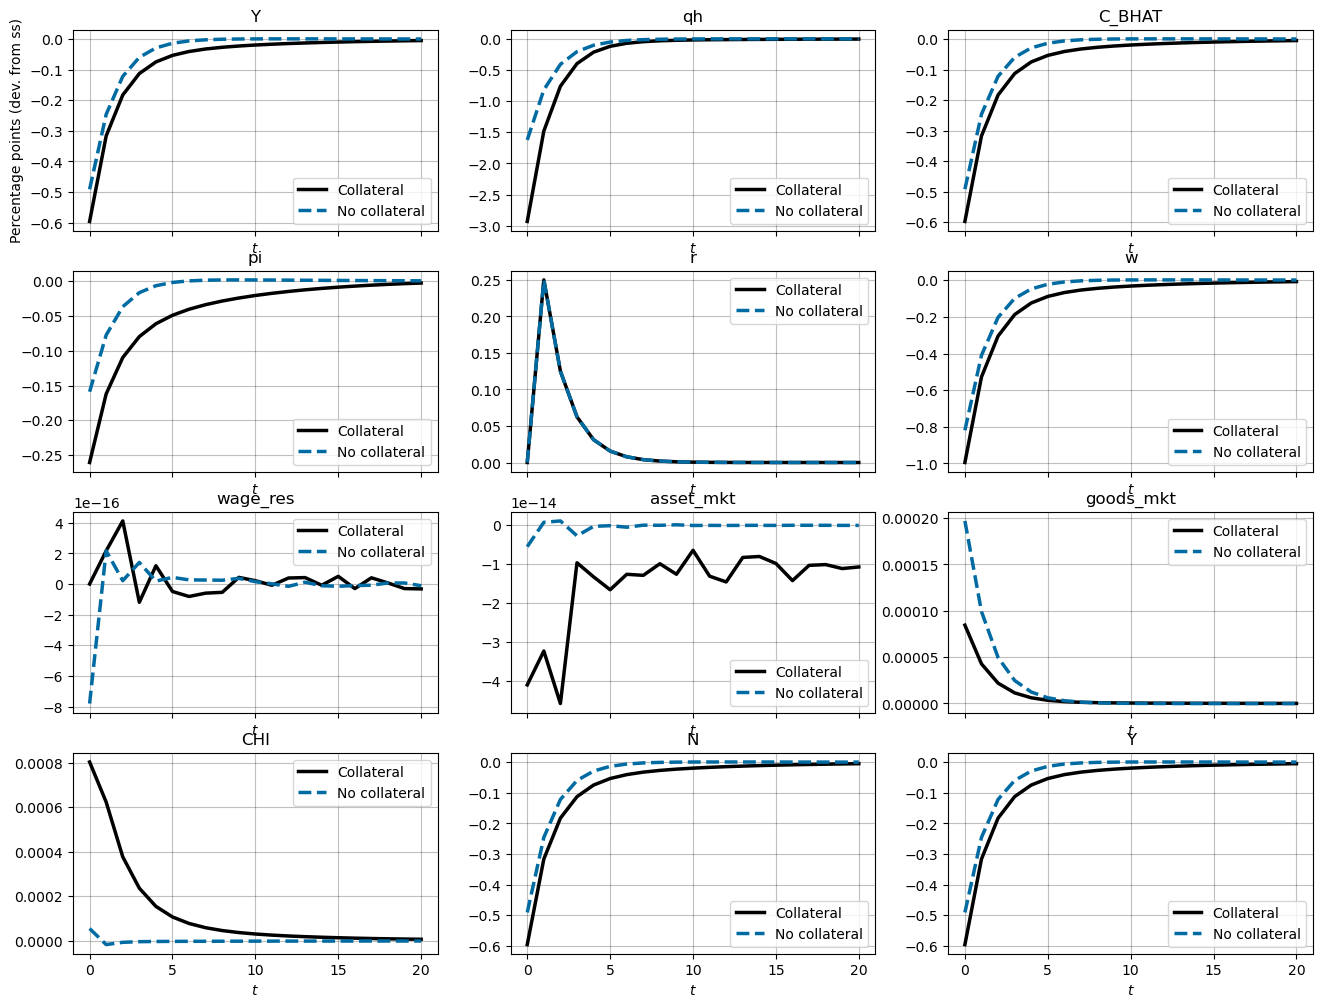

In [42]:
utils.show_irfs([irfs_col, irfs_nocol], ['Y', 'qh', 'C_BHAT', 'pi', 'r', 'w',
                                        'wage_res', 'asset_mkt', 'goods_mkt', 'CHI', 'N', 'Y'], 
                                        labels=["Collateral", "No collateral"], T_plot = 21, figsize=(16,12))

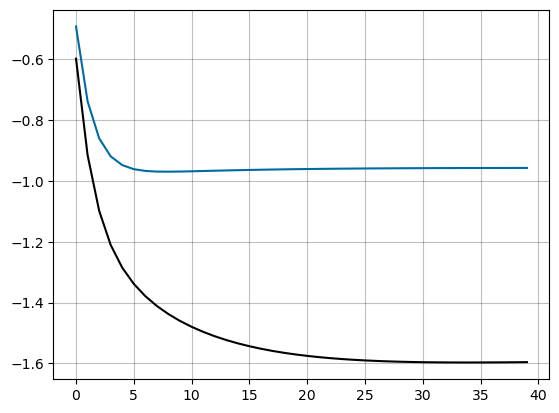

In [43]:
C_cum_col = np.cumsum(irfs_col['C_BHAT'])
C_cum_nocol = np.cumsum(irfs_nocol['C_BHAT'])

plt.plot(100*C_cum_col[:40])
plt.plot(100*C_cum_nocol[:40])

### 2.1.1. Plotting the DAG for the model

In [ ]:
drawdag(hank, exogenous, unknowns, targets)

## 2.2. Computing impulse-response functions

### 2.2.1. Computing the non-linear impulse-response functions

In [ ]:
irfs = SimpleNamespace()
# construct the shock path for rstar
rho_r, sig_r = 0.65, 0.01
rho_gamma, sig_gamma = 0.9, 0.15

ss_highleverage = hank.steady_state(ss0)
ss_lowleverage = hank.steady_state(ss_ll)

rstar_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
gamma_path = {"gamma": sig_gamma * rho_gamma ** (np.arange(T))}

control = {"gamma": sig_gamma * rho_gamma ** (np.arange(T))}
shock = {"rstar": sig_r * rho_r ** (np.arange(T)), "gamma": sig_gamma * rho_gamma ** (np.arange(T))}
shock_nogam = {"rstar": sig_r * rho_r ** (np.arange(T))}

# compute nonlinear impulse responses
shock_control = True
if shock_control:
    irfs.control = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, control)
    irfs.shock = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, shock)

    irfs.shock_nogam = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, shock_nogam)

# # compute nonlinear impulse responses
hl_ll = False
if hl_ll:
    irfs.highleverage = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_path)
    irfs.lowleverage = hank.solve_impulse_nonlinear(ss_lowleverage, unknowns, targets, rstar_path)

In [ ]:
irfs_shock_control = irfs.shock['C_BHAT'] - irfs.control['C_BHAT']
ifrs_shock_nogam = irfs.shock_nogam['C_BHAT']

plt.plot(100*irfs_shock_control[:21], label='High leverage')
plt.plot(100*ifrs_shock_nogam[:21], label = 'Low leverage')
plt.title('Consumption response to a monetary policy shock')
plt.legend()
plt.show()

In [ ]:
utils.show_irfs([irfs.highleverage, irfs.lowleverage], ['Y', 'qh', 'C_BHAT', 
                                                        'pi', 'r', 'w'], labels=["High leverage", "Low leverage"], T_plot = T, figsize=(18,8))

## 2.3. Decomposing a monetary policy shock

Decomposing the effects of a monetary policy shock on consumption

In [296]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']

ss_highleverage = hank.steady_state(ss0)
ss_lowleverage = hank.steady_state(ss_ll)

# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.lowleverage = SimpleNamespace()
decomp.highleverage = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.lowleverage = SimpleNamespace()
irf.highleverage = SimpleNamespace()

Js_ll = {'hh1': hh1.jacobian(ss_lowleverage, inputs = input_list, 
                          outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

Js_hl = {'hh1': hh1.jacobian(ss_highleverage, inputs = input_list, 
                          outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

rho_r, sig_r = 0.5, 0.01
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

irf.lowleverage = hank.solve_impulse_nonlinear(ss_lowleverage, unknowns, targets, rstar_shock, Js = Js_ll, verbose = False)
irf.highleverage = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_shock, Js = Js_hl, verbose = False)

for k in input_list:
    setattr(decomp.lowleverage, f'dC_d{k}', Js_ll['hh1']['C_BHAT'][k] @ irf.lowleverage[k])
    setattr(decomp.highleverage, f'dC_d{k}', Js_hl['hh1']['C_BHAT'][k] @ irf.highleverage[k])

In [ ]:
col_list = [0, 5, 10, 15, 20]
J_cols = [{'qh':Js_hl['hh1']['C_BHAT']['qh'][:, i], 'qh_lag':Js_hl['hh1']['C_BHAT']['qh_lag'][:, i]} \
          for i in col_list]

utils.show_irfs(J_cols, ['qh', 'qh_lag'], labels=col_list)

plt.plot(J_cols[0]['qh'] + J_cols[1]['qh_lag'])

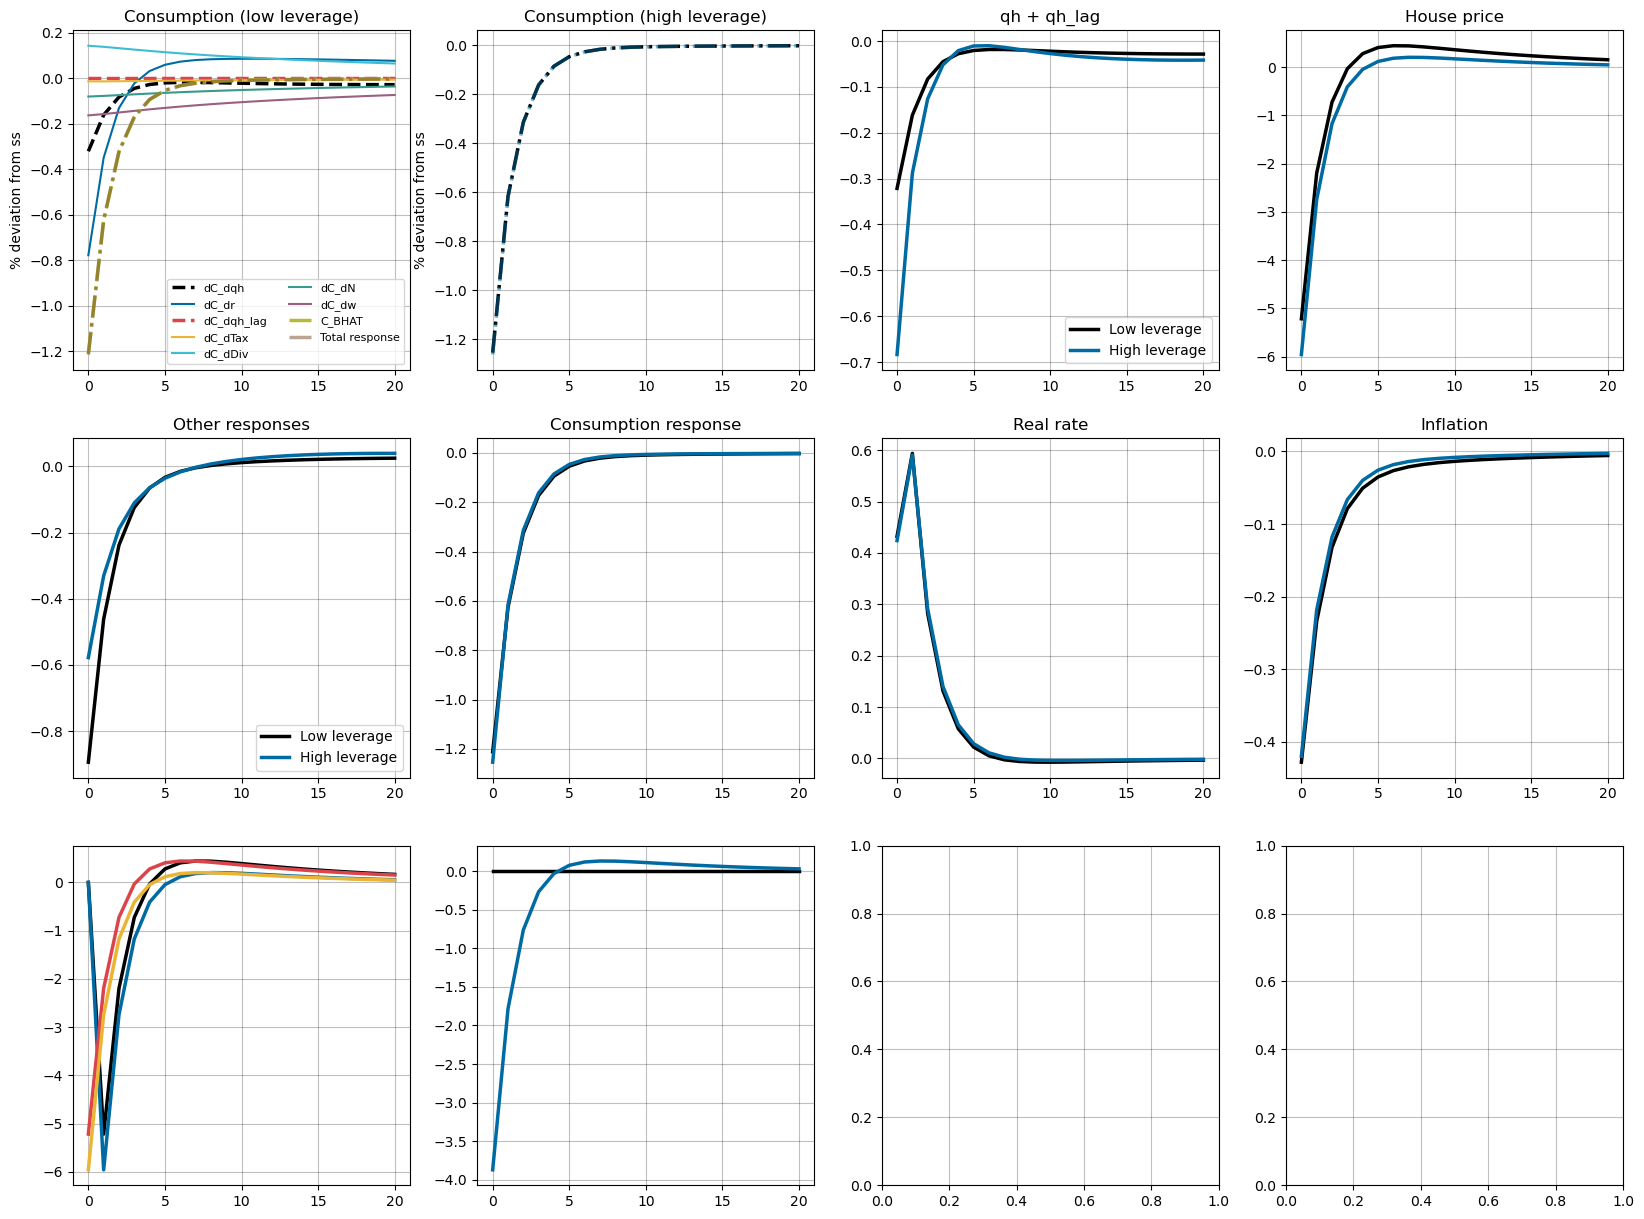

In [ ]:
decomp_dict_ll = vars(decomp.lowleverage)
decomp_dict_hl = vars(decomp.highleverage)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value
    
ncols = 4
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(20,15))
ax = ax.flatten()

for (key, value) in decomp_dict_ll.items():
    if key != 'dC_dqh' and key != 'dC_dqh_lag':
        ax[0].plot(100*value[:21], label = key)
    else:
        ax[0].plot(100*value[:21], label = key, linestyle='--', linewidth=2.5)

    # ax[0].plot(100*value[:21], label = key)

ax[0].plot(100*irf.lowleverage['C_BHAT'][:21], label = 'C_BHAT', linestyle='dashdot', linewidth=2.5)
ax[0].plot(100*total_response_ll[:21], label = 'Total response', linestyle='dashdot', linewidth=2.5, alpha = 0.5)
ax[0].legend(ncols = 2, fontsize = 8)
ax[0].set_title('Consumption (low leverage)')
ax[0].set_ylabel('% deviation from ss')
# ax[0].set_ylim(-8.0, 4.0)

for (key, value) in decomp_dict_hl.items():
    if key != 'dC_dqh' and key != 'dC_dqh_lag':
        ax[1].plot(100*value[:21], label = key)
    else:
        ax[1].plot(100*value[:21], label = key, linestyle='--', linewidth=2.5)

ax[1].plot(100*irf.highleverage['C_BHAT'][:21], label = 'C_BHAT', linestyle='dashdot', linewidth=2.5)
ax[1].plot(100*total_response_hl[:21], label = 'Total response', linestyle='dashdot', linewidth=2.5, alpha = 0.5)
# ax[1].legend(ncols = 2, fontsize = 8)
ax[1].set_title('Consumption (high leverage)')
ax[1].set_ylabel('% deviation from ss')
# ax[1].set_ylim(-8.0, 4.0)

# ax[1].plot(100*irf['qh'][:21], linewidth=2.5)
# ax[1].set_title('House price')

ax[2].plot(100*(decomp.lowleverage.dC_dqh[:21] + decomp.lowleverage.dC_dqh_lag[:21]), linewidth=2.5, label = 'Low leverage')
ax[2].plot(100*(decomp.highleverage.dC_dqh[:21] + decomp.highleverage.dC_dqh_lag[:21]), linewidth=2.5, label = 'High leverage')
ax[2].set_title('qh + qh_lag')
ax[2].legend()

ax[3].plot(100*irf.lowleverage['qh'][:21], linewidth=2.5, label = 'Low leverage')
ax[3].plot(100*irf.highleverage['qh'][:21], linewidth=2.5, label = 'High leverage')
ax[3].set_title('House price')

ax[4].plot(100*(total_response_ll[:21] - (decomp.lowleverage.dC_dqh[:21] + decomp.lowleverage.dC_dqh_lag[:21])), linewidth=2.5, label = 'Low leverage')
ax[4].plot(100*(total_response_hl[:21] - (decomp.highleverage.dC_dqh[:21] + decomp.highleverage.dC_dqh_lag[:21])), linewidth=2.5, label = 'High leverage')
ax[4].set_title('Other responses')
ax[4].legend()

ax[5].plot(100*irf.lowleverage['C_BHAT'][:21], linewidth=2.5, label = 'Low leverage')
ax[5].plot(100*irf.highleverage['C_BHAT'][:21], linewidth=2.5, label = 'High leverage')
ax[5].set_title('Consumption response')

ax[6].plot(100*irf.lowleverage['r'][:21], linewidth=2.5, label = 'Low leverage')
ax[6].plot(100*irf.highleverage['r'][:21], linewidth=2.5, label = 'High leverage')
ax[6].set_title('Real rate')

ax[7].plot(100*irf.lowleverage['pi'][:21], linewidth=2.5, label = 'Low leverage')
ax[7].plot(100*irf.highleverage['pi'][:21], linewidth=2.5, label = 'High leverage')
ax[7].set_title('Inflation')

ax[8].plot(100*irf.lowleverage['qh_lag'][:21], linewidth=2.5, label = 'Low leverage')
ax[8].plot(100*irf.highleverage['qh_lag'][:21], linewidth=2.5, label = 'High leverage')
ax[8].plot(100*irf.lowleverage['qh'][:21], linewidth=2.5, label = 'Low leverage')
ax[8].plot(100*irf.highleverage['qh'][:21], linewidth=2.5, label = 'High leverage')

ax[9].plot(100*irf.lowleverage['B_BHAT'][:21], linewidth=2.5, label = 'Low leverage')
ax[9].plot(100*irf.highleverage['B_BHAT'][:21], linewidth=2.5, label = 'High leverage')

plt.show()

## 2.4. Government spending shock

In [ ]:
irfs = SimpleNamespace()
# construct the shock path for rstar
rho_G = 0.8
rho_B = 0.9
dG = 0.01 * rho_G ** np.arange(T)
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks = {'G': dG, 'B': dB}

irfs.Gshock = hank.solve_impulse_nonlinear(ss, unknowns, targets, shocks)

utils.show_irfs([irfs.Gshock], ['Y', 'qh', 'C_BHAT', 
                                'pi', 'r', 'G', 'asset_mkt'], labels=["High leverage", "Low leverage"], T_plot = T, figsize=(18,8))

## 2.5. Permanent credit shocks (not implemented yet)

In [ ]:
from sequence_jacobian.classes import FactoredJacobianDict
calibration_new = calibration.copy()
calibration_new['gamma'] = 0.6

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
ss_new =  hank_ss.steady_state(ss0)

H_U = hank.jacobian(ss_new, unknowns, targets, T=T)
H_U_factored = FactoredJacobianDict(H_U, T)

In [ ]:
sigma_gamma = -0.2
rho_gamma = 1.0

irfs = SimpleNamespace()
gamma_shock = {"gamma": sigma_gamma * rho_gamma ** (np.arange(T))}
gamma_shock_pos = {"gamma": -sigma_gamma * rho_gamma ** (np.arange(T))}

irfs.gamma_neg = hank.solve_impulse_nonlinear(ss_new, unknowns, targets, gamma_shock, H_U_factored=H_U_factored)
irfs.gamma_pos = hank.solve_impulse_nonlinear(ss_new, unknowns, targets, gamma_shock_pos, H_U_factored=H_U_factored)

utils.show_irfs([irfs.gamma_neg, irfs.gamma_pos], ['Y', 'qh', 'C_BHAT', 'pi',
                               'r', 'w', 'asset_mkt', 'goods_mkt', 'house_mkt', 
                               'CHI'], labels=["neg", "pos"], T_plot = 50, figsize=(18,12.5))

In [ ]:
gamma_path = np.zeros(T)

TT = 10
gamma_path[:TT] = np.linspace(0, sigma_gamma, TT)
gamma_path[TT-1:] = sigma_gamma * rho_gamma ** (np.arange(T-TT+1))
plt.plot(gamma_path)
plt.xlim(0, TT + 5)


In [ ]:
sigma_gamma = -0.1
rho_gamma = 0.6

gamma_path = np.zeros(T)
TT = 10
gamma_path[:TT] = np.linspace(0, sigma_gamma, TT)
gamma_path[TT-1:] = sigma_gamma * rho_gamma ** (np.arange(T-TT+1))

irfs = SimpleNamespace()
gamma_shock = {"gamma": gamma_path}
gamma_shock_pos = {"gamma": -gamma_path}

irfs.gamma_neg = hank.solve_impulse_nonlinear(ss, unknowns, targets, gamma_shock, options={'verbose': False})
irfs.gamma_pos = hank.solve_impulse_nonlinear(ss, unknowns, targets, gamma_shock_pos)

utils.show_irfs([irfs.gamma_neg, irfs.gamma_pos], ['Y', 'qh', 'C_BHAT', 'pi',
                               'r', 'w', 'asset_mkt', 'goods_mkt', 'house_mkt', 
                               'CHI', 'gamma'], labels=["Negative LTV shock", "Positive LTV shock"], T_plot = 50, figsize=(18,12.5))

In [ ]:
sigma_gamma = 0.1
rho_gamma = 0.3
gamma_path = np.zeros(T)
TT = 10
gamma_path[:TT] = np.linspace(0, sigma_gamma, TT)
gamma_path[TT-1:] = sigma_gamma * rho_gamma ** (np.arange(T-TT+1))

sigma_gamma_bb = 0.2
gamma_path_bb = np.zeros(T)
TT = 10
gamma_path_bb[:TT] = np.linspace(0, sigma_gamma_bb, TT)
gamma_path_bb[TT-1:] = sigma_gamma_bb * rho_gamma ** (np.arange(T-TT+1))

irfs = SimpleNamespace()
gamma_shock = {"gamma": gamma_path}
gamma_shock_pos = {"gamma": gamma_path_bb}

irfs.gamma_neg = hank.solve_impulse_nonlinear(ss, unknowns, targets, gamma_shock)
irfs.gamma_pos = hank.solve_impulse_nonlinear(ss, unknowns, targets, gamma_shock_pos)

utils.show_irfs([irfs.gamma_neg, irfs.gamma_pos], ['Y', 'qh', 'C_BHAT', 'pi',
                               'r', 'w', 'asset_mkt', 'goods_mkt', 'house_mkt', 
                               'CHI', 'gamma', 'H_BHAT'], labels=["LTV up 100 bps", "LTV up 150 bps"], T_plot = 50, figsize=(18,12.5))

In [ ]:
utils.show_irfs([irfs.gamma], ['Y', 'qh', 'C_BHAT', 
                               'pi', 'r', 'w'], labels=["High leverage"], T_plot = 21, figsize=(18,8))

## 2.6 Isolating the collateral effects in the model

In [331]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_lag']

calibration = {'gamma': 0.8, 'theta': 0.97, 'sigma': 1.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
               'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}

# calibration['alpha'] = 0.055
calibration['rstar'] = 0.03/4
calibration['gamma'] = 0.65

unknowns_ss = {'beta': 0.9793721660932323, 'varphi': 0.808535783494474, 'qh': 5.833330693740451}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
ss =  hank_ss.steady_state(ss0)

ss_highleverage = hank.steady_state(ss0)

# empty namespace to store irfs
irf = SimpleNamespace()
irf.rstar = SimpleNamespace()
irf.rstargamma = SimpleNamespace()


# Js_hl = {'hh1': hh1.jacobian(ss_highleverage, inputs = input_list, 
#                           outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

rho_r, sig_r = 0.5, 0.01
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

rho_gamma = 0.2
sigma_gamma = 0.025
TT = 10
# dgamma = sigma_gamma * rho_gamma ** (np.arange(T))
dgamma = np.zeros(T)
dgamma[0] = 0.0133
dgamma[1] = 0.0067
dgamma[2] = 0.0038
dgamma[3] = 0.0013
dgamma[4] = 0.001
dgamma[5] = 0.0003
dgamma[6] = 0.0003
# dgamma[:TT] = 0.01
# dgamma[TT-1:] = 0.01 * rho_gamma ** (np.arange(T-TT+1))

rstar_gamma_shock = {"rstar": dr, "gamma": dgamma}
# rstar_gamma_shock = {"gamma": dgamma}

irf.rstar = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_shock, verbose = False)
irf.rstargamma = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_gamma_shock, verbose = False)

# from scipy.optimize import minimize
# def objective(gamma_path, ss_highleverage, unknowns, targets):
#     dgamma = np.zeros(T)
#     dgamma[:6] = gamma_path
#     rstar_gamma_shock = {"rstar": dr, "gamma": dgamma}
#     irf = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_gamma_shock, verbose = True)
#     objective = np.sum((irf['B_BHAT'][:10])**2)

#     return objective

# # Define the optimization function
# def optimize_shocks(ss_highleverage, unknowns, targets, T, maxiter=3):
#     # Initial guess for shocks (concatenate dr and dgamma)
#     # initial_guess = np.zeros(T)
#     initial_guess = [0.012, 0.06, 0.03, 0.01, 0.015, 0.03]
#     # Run the optimization
#     result = minimize(objective, initial_guess, args=(ss_highleverage, unknowns, targets), options={'maxiter': maxiter})

#     if not result.success and result.nit == maxiter:
#         print("Maximum number of iterations reached.")

#     return result

# optimal_dr = optimize_shocks(ss_highleverage, unknowns, targets, T)

3 3


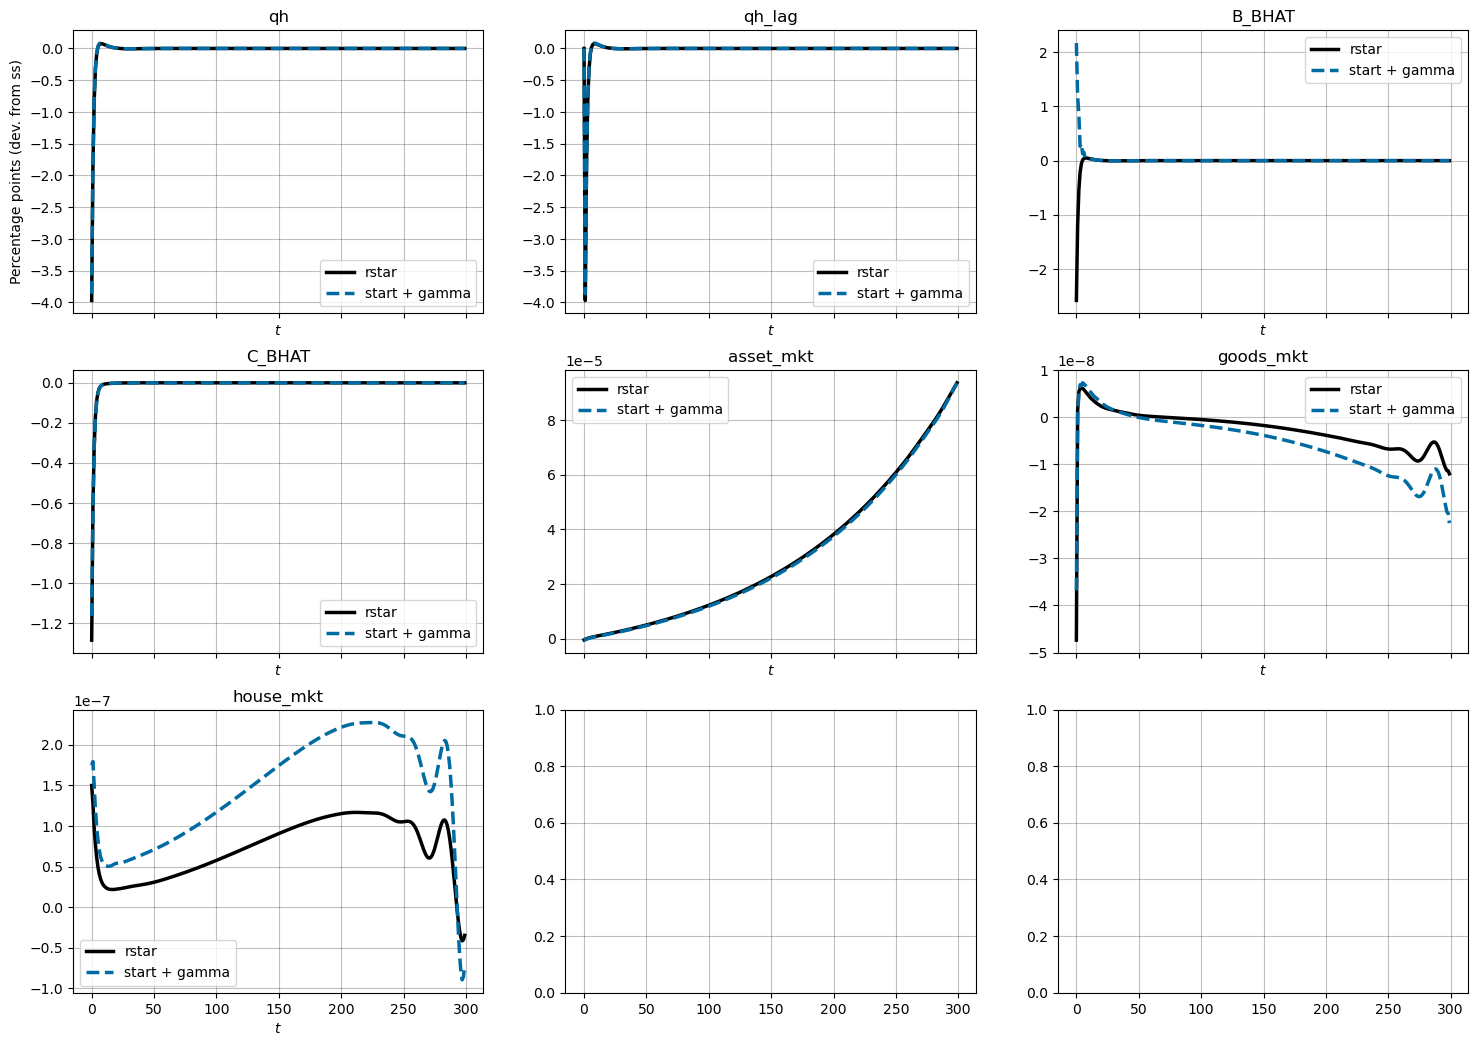

In [332]:
utils.show_irfs([irf.rstar, irf.rstargamma], ['qh', 'qh_lag', 'B_BHAT', 'C_BHAT','asset_mkt', 
                                              'goods_mkt', 'house_mkt'], labels=["rstar", "start + gamma"], T_plot = 300, figsize=(18,12.5))

### 2.6.1. Decomposing the shock

In [316]:
# input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma']
# input_list_nogam = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']

# ss = hank.steady_state(ss0)

# # empty namespace to store decompositions
# decomp = SimpleNamespace()
# decomp.lowleverage = SimpleNamespace()
# decomp.highleverage = SimpleNamespace()

# # empty namespace to store irfs
# irf = SimpleNamespace()
# irf.lowleverage = SimpleNamespace()
# irf.highleverage = SimpleNamespace()

# Js_ll = {'hh1': hh1.jacobian(ss, inputs = input_list_nogam, 
#                           outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

# Js_hl = {'hh1': hh1.jacobian(ss, inputs = input_list, 
#                           outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

# rho_r, sig_r = 0.5, 0.01
# dr = sig_r * rho_r ** (np.arange(T))
# rstar_shock = {"rstar": dr}

# # dgamma = np.zeros(T)
# # dgamma[0] = 0.0133
# # dgamma[1] = 0.0067
# # dgamma[2] = 0.0038
# # dgamma[3] = 0.0013
# # dgamma[4] = 0.001
# # dgamma[5] = 0.0003
# # dgamma[6] = 0.0003
# # rstar_gamma_shock = {"rstar": dr, "gamma": dgamma}

# irf.lowleverage = hank.solve_impulse_nonlinear(ss_lowleverage, unknowns, targets, rstar_shock, Js = Js_ll, verbose = False)
# # irf.highleverage = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_gamma_shock, Js = Js_hl, verbose = False)

# for k in input_list_nogam:
#     setattr(decomp.lowleverage, f'dC_d{k}', Js_ll['hh1']['C_BHAT'][k] @ irf.lowleverage[k])
# # for k in input_list:
# #     setattr(decomp.highleverage, f'dC_d{k}', Js_hl['hh1']['C_BHAT'][k] @ irf.highleverage[k])

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
input_list_gamma = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']

ss_highleverage = hank.steady_state(ss0)
ss_lowleverage = hank.steady_state(ss_ll)

# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.lowleverage = SimpleNamespace()
decomp.highleverage = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.lowleverage = SimpleNamespace()
irf.highleverage = SimpleNamespace()

Js_ll = {'hh1': hh1.jacobian(ss_highleverage, inputs = input_list, 
                          outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

Js_hl = {'hh1': hh1.jacobian(ss_highleverage, inputs = input_list_gamma, 
                          outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

rho_r, sig_r = 0.5, 0.01
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

dgamma = np.zeros(T)
dgamma[0] = 0.0133
dgamma[1] = 0.0067
dgamma[2] = 0.0038
dgamma[3] = 0.0013
dgamma[4] = 0.001
dgamma[5] = 0.0003
dgamma[6] = 0.0003
rstar_gamma_shock = {"rstar": dr, "gamma": dgamma}

irf.lowleverage = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_shock, Js = Js_ll, verbose = False)
irf.highleverage = hank.solve_impulse_nonlinear(ss_highleverage, unknowns, targets, rstar_gamma_shock, verbose = False)

for k in input_list:
    setattr(decomp.lowleverage, f'dC_d{k}', Js_ll['hh1']['C_BHAT'][k] @ irf.lowleverage[k])

for k in input_list_gamma:
    setattr(decomp.highleverage, f'dC_d{k}', Js_hl['hh1']['C_BHAT'][k] @ irf.highleverage[k])

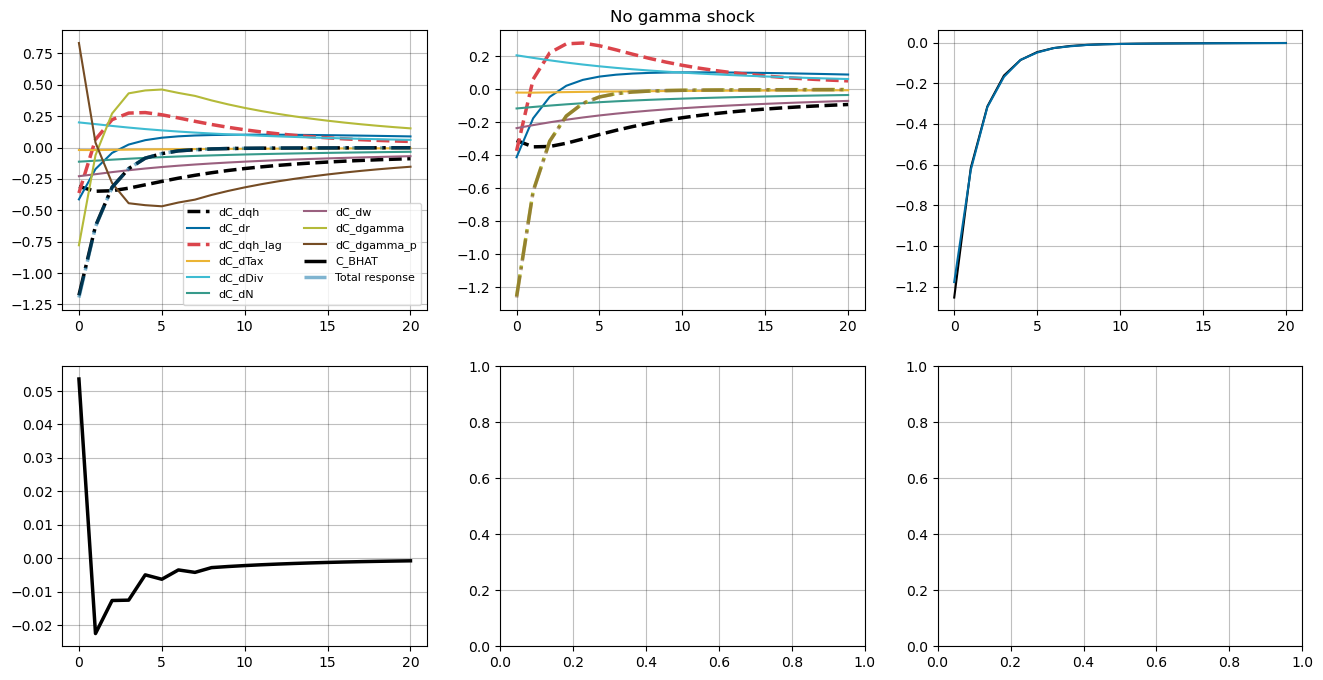

In [323]:
decomp_dict_ll = vars(decomp.lowleverage)
decomp_dict_hl = vars(decomp.highleverage)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value
    
ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(16,8))
ax = ax.flatten()

for (key, value) in decomp_dict_hl.items():
    if key != 'dC_dqh' and key != 'dC_dqh_lag':
        ax[0].plot(100*value[:21], label = key)
    else:
        ax[0].plot(100*value[:21], label = key, linestyle='--', linewidth=2.5)
ax[0].plot(100*irf.highleverage['C_BHAT'][:21], label = 'C_BHAT', linestyle='dashdot', linewidth=2.5)
ax[0].plot(100*total_response_hl[:21], label = 'Total response', linestyle='dashdot', linewidth=2.5, alpha = 0.5)
ax[0].legend(ncols = 2, fontsize = 8)

for (key, value) in decomp_dict_ll.items():
    if key != 'dC_dqh' and key != 'dC_dqh_lag':
        ax[1].plot(100*value[:21], label = key)
    else:
        ax[1].plot(100*value[:21], label = key, linestyle='--', linewidth=2.5)
ax[1].plot(100*irf.lowleverage['C_BHAT'][:21], label = 'C_BHAT', linestyle='dashdot', linewidth=2.5)
ax[1].plot(100*total_response_ll[:21], label = 'Total response', linestyle='dashdot', linewidth=2.5, alpha = 0.5)

ax[1].set_title('No gamma shock')

ax[2].plot(100*irf.lowleverage['C_BHAT'][:21])
ax[2].plot(100*irf.highleverage['C_BHAT'][:21])

ax[3].plot(100*(decomp.highleverage.dC_dgamma[:21] + decomp.highleverage.dC_dgamma_p[:21]), linewidth=2.5, label = 'Low leverage')

# 3. Comparing monetary policy under different leverage levels

Computing the steady state of an economy with a leverage of $\gamma = 0.3$ and $\gamma = 0.8$.

In [ ]:
# load the HA block and add inputs
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]
hank_ss_sep = create_model(blocks_ss, name="One-Asset HANK SS")

cali_lowleverage = {'gamma': 0.35, 'theta': 0.1, 'sigma': 1.0, 'alpha': 0.3, 'bmax': 45,
                    'hmax': 5.0, 'kmax': 1, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3,
                    'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                    'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 5.6, 'HBAR': 1.0}

cali_highleverage = cali_lowleverage.copy()
cali_highleverage['gamma'] = 0.8

unknowns_ss = {'beta': 0.986, 'varphi': 0.08345079332201338, 'qh': 8.845303164603399}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

calib_lowleverage = hank_ss_sep.solve_steady_state(cali_lowleverage, unknowns_ss, targets_ss, solver="hybr")
ss_lowleverage =  hank_ss_sep.steady_state(calib_lowleverage)

calib_highleverage = hank_ss_sep.solve_steady_state(cali_highleverage, unknowns_ss, targets_ss, solver="hybr")
ss_highleverage =  hank_ss_sep.steady_state(calib_highleverage)

Computing the transitional dyanmics in each of the two series

In [ ]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc, qhouse_lag]
hank = create_model(blocks, name="Housing HANK")

In [ ]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
# G_lowleverage = hank.solve_jacobian(ss_lowleverage, unknowns, targets, exogenous, T=T)
# G_highleverage = hank.solve_jacobian(ss_highleverage, unknowns, targets, exogenous, T=T)

In [ ]:
rho_r, sig_r = 0.75, 0.01
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
irf_lowleverage = hank.solve_impulse_linear(ss_lowleverage, unknowns, targets, rstar_shock_path)
irf_highleverage = hank.solve_impulse_linear(ss_highleverage, unknowns, targets, rstar_shock_path)

In [ ]:
plt.plot(irf_lowleverage['asset_mkt'][:21], label='Low leverage', linestyle='-', linewidth=2.5)
plt.plot(irf_highleverage['asset_mkt'][:21], label='High leverage', linestyle='--', linewidth=2.5)
plt.legend()
plt.show()

# Appendix A. Debugging the policy functions

## A.1. Setting up the same calibration as for general equilibrium

In [ ]:
import warnings
warnings.simplefilter('always', RuntimeWarning)

b_bhat_grid, h_bhat_grid, k_grid, e_grid, Pi, b_grid = utils.make_grids(bmax, hmax, kmax, nB, nH, nK, nZ, rho_z, sigma_z, gamma, qh_lag)
z_grid = utils.income(e_grid, tax, w, N)

# use backward induction to solve for the steady state policy functions
Vh_p, Vb_p, h_bhat, b_bhat, c_bhat, _ = utils.policy_ss(Pi, h_bhat_grid, b_bhat_grid, z_grid, e_grid, k_grid, beta, 
                                         gamma, theta, sigma, qh, qh_lag, r, alpha, tol=1E-8, max_iter=5_000, debug = False)

c, h, b, b_endo = utils.bhat_to_b(h_bhat_grid, b_bhat_grid, b_grid, z_grid, c_bhat, h_bhat, gamma, alpha, r, qh, qh_lag)

# Appendix B. Old figures

## B.1. Plotting the response for different persistence

In [ ]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
dqh = G['qh']['rstar'] @ drstar
dN = G['C_BHAT']['rstar'] @ drstar
ax.plot(10000 * dpi[:21])
ax.set_title('Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend([f'rho = {rho}' for rho in rhos])

ax2.plot(10000 * dqh[:21])
ax2.set_title('House prices')
ax2.set_xlabel('quarters')
ax2.set_ylabel('bp deviation from ss')

ax3.plot(10000 * dN[:21])
ax3.set_title('Consumption')
ax3.set_xlabel('quarters')
ax3.set_ylabel('bp deviation from ss')

plt.show()

qh_lag_level = G['qh']['rstar'] @ drstar + ss['qh']
B_BHAT_level = G['B_BHAT']['rstar'] @ drstar + ss['B_BHAT']
B_level = B_BHAT_level - ss['gamma']*qh_lag_level*ss['H_BHAT']
leverage = B_level/(qh_lag_level*ss['H_BHAT'])

plt.plot(100*leverage[:21])
# plt.plot(B_level)
# plt.ylim(0.08, 0.1)
plt.show()

rho_r, sig_r = 0.8, -0.01
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

print(td_lin.keys())

# plt.plot(td_lin['asset_mkt'][:21])
utils.show_irfs([td_lin], ['asset_mkt', 'goods_mkt', 'house_mkt'])

## B.2. Plotting the state space

In [ ]:
b_endo = ss.internals['hh_housecons']['b_bhat_grid'][None,:] - \
ss['qh_lag']*ss['gamma']*ss.internals['hh_housecons']['h_bhat_grid'][:,None]

print(b_endo.shape)

for iH in range(0, ss['nB']):
    plt.plot(b_endo[:,iH], ss.internals['hh_housecons']['h_bhat_grid'])